In [1]:
import numpy as np
from numpy import asarray
from numpy import savetxt, loadtxt

%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from pathlib import Path

from multiprocessing.pool import ThreadPool
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
from google.colab import files, drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [3]:
from skimage.io import imread
import os
root = 'facades'

from IPython.display import clear_output

import torchsummary

### Datasets

https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/

"Architectural labels→photo 400 training images from
[45], trained for 200 epochs, batch size 1, with random jitter
and mirroring. Data were split into train and test randomly."

In [4]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/facades.zip

--2021-01-09 16:49:20--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/facades.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35135868 (34M) [application/zip]
Saving to: ‘facades.zip’

facades.zip         100%[===================>]  33.51M  2.89MB/s    in 9.9s    

2021-01-09 16:49:30 (3.38 MB/s) - ‘facades.zip’ saved [35135868/35135868]



In [5]:
!unzip facades.zip
!ls

Archive:  facades.zip
   creating: facades/trainA/
  inflating: facades/trainA/110_A.jpg  
  inflating: facades/trainA/324_A.jpg  
  inflating: facades/trainA/353_A.jpg  
  inflating: facades/trainA/319_A.jpg  
  inflating: facades/trainA/20_A.jpg  
  inflating: facades/trainA/274_A.jpg  
  inflating: facades/trainA/107_A.jpg  
  inflating: facades/trainA/338_A.jpg  
  inflating: facades/trainA/140_A.jpg  
  inflating: facades/trainA/225_A.jpg  
  inflating: facades/trainA/268_A.jpg  
  inflating: facades/trainA/44_A.jpg  
  inflating: facades/trainA/393_A.jpg  
  inflating: facades/trainA/54_A.jpg  
  inflating: facades/trainA/24_A.jpg  
  inflating: facades/trainA/77_A.jpg  
  inflating: facades/trainA/61_A.jpg  
  inflating: facades/trainA/298_A.jpg  
  inflating: facades/trainA/244_A.jpg  
  inflating: facades/trainA/333_A.jpg  
  inflating: facades/trainA/357_A.jpg  
  inflating: facades/trainA/303_A.jpg  
  inflating: facades/trainA/178_A.jpg  
  inflating: facades/trainA/282_A.j

### Обработка изображений

Создаём класс с загрузкой изображений и их обработкой

1. Im -> (286, 286) -> Random Cropp (256, 256)
2. Зеркальное отображение с p = 0.5
3. Random Jitter

In [6]:
class FacadesDataset(Dataset):
  
    def __init__(self, mode):
        super().__init__()
        params = {'len': {"train": 400, "test": 106, "val": 100}
                  }

        self.mode = mode     
        self.len_ = params['len'][mode]
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, i):
      if self.mode == 'train':
        image = imread(os.path.join(root, 'trainA/' + str(i) + '_A.jpg') ) / 255
        mask = imread(os.path.join(root, 'trainB/' + str(i) + '_B.jpg') ) / 255
        return torch.Tensor([image, mask])
      elif self.mode == 'test':
        image = imread(os.path.join(root, 'testA/' + str(i) + '.jpg') ) / 255
        mask = imread(os.path.join(root, 'testB/' + str(i) + '.jpg') ) / 255
        return torch.Tensor([image, mask])
      else:
        mask = imread('file.jpg') / 255
        print(mask.shape)
        return torch.Tensor([mask])
  
    def __getitem__(self, index):
        if self.mode == 'train':
          transform = transforms.Compose([
              transforms.Resize((286,286)),
              transforms.RandomCrop(256),
              transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
              transforms.RandomHorizontalFlip(p=0.5),
              transforms.Normalize([0.45, 0.45, 0.45], [0.25, 0.25, 0.25]) 
          ])
        elif self.mode == 'test':
          transform = transforms.Compose([
              transforms.Normalize([0.45, 0.45, 0.45], [0.25, 0.25, 0.25])  
          ])
        else:
          transform = transforms.Compose([
              transforms.Resize((256,256)),
              transforms.Normalize([0.45, 0.45, 0.45], [0.25, 0.25, 0.25])  
          ])
        x = self.load_sample(index).permute( (0, 3, 1, 2) )
        x = transform( x )
        return x

In [7]:
train_dataset = FacadesDataset(mode = 'train')
val_dataset = FacadesDataset(mode = 'test')

In [8]:
a = train_dataset[5]

In [9]:
len(a), a[0].shape, a[1].shape

(2, torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [10]:
torch.mean(a[0]), torch.mean(a[1])

(tensor(-0.1096), tensor(-0.0815))

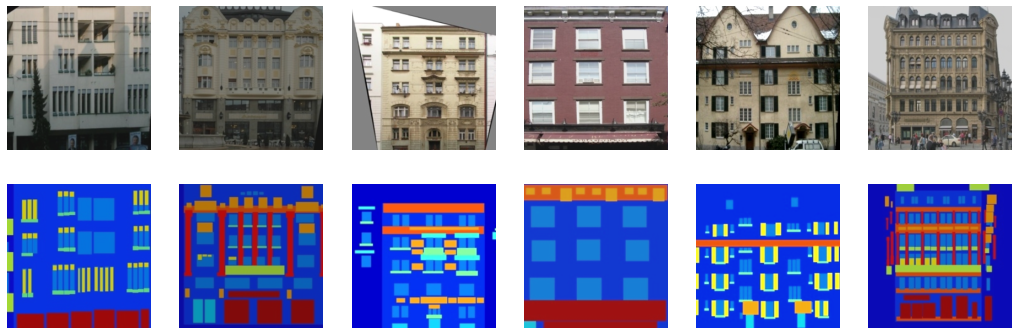

In [11]:
t = []

plt.figure(figsize=(18, 6))
for i in range(6):
    a = train_dataset[i+1]
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(a[0].permute( (1, 2, 0) ) * 0.25 + 0.45 )

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(a[1].permute( (1, 2, 0) ) * 0.25 + 0.45 )

    t.append( (a[0].mean(), a[0].std(), a[1].mean(), a[1].std() ) )
plt.show();

### Model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
def normal_init(m, mean, std):
    if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
    
        # input 256
        # C64-C128-C256-C512 #-C512-C512
        # All ReLU leaky(0.2), no B-N to 64
        self.enc_conv0 = nn.Sequential( nn.Conv2d(6, 64, 4, stride = 2, padding = 1), nn.ReLU() ) # 128
        self.enc_conv1 = nn.Sequential( nn.Conv2d(64, 128, 4, stride = 2, padding = 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2) ) # 64
        self.enc_conv2 = nn.Sequential( nn.Conv2d(128, 256, 4, stride = 2, padding = 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2) ) # 32
        self.enc_conv3 = nn.Sequential( nn.Conv2d(256, 512, 4, stride = 2, padding = 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2) ) # 16
        self.enc_conv6 = nn.Sequential( nn.Conv2d(512, 1, 4, stride = 2), nn.Sigmoid() )
        self.weight_init()

    def weight_init(self):
      for block in self._modules:
        try:
          for m in self._modules[block]:
            normal_init(m, 0, 0.02)
        except:
          normal_init(block)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x) 
        e1 = self.enc_conv1(e0) 
        e2 = self.enc_conv2(e1) 
        e3 = self.enc_conv3(e2) 
        e6 = self.enc_conv6(e3) 

        return e6

In [14]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # input 256

        # encoder (downsampling)
        # C64-C128-C256-C512-C512-C512-C512-C512
        self.enc_conv0 = nn.Sequential( nn.Conv2d(3, 64, 4, stride = 2, padding = 1), nn.ReLU() ) # 128
        self.enc_conv1 = nn.Sequential( nn.Conv2d(64, 128, 4, stride = 2, padding = 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2) ) # 64
        self.enc_conv2 = nn.Sequential( nn.Conv2d(128, 256, 4, stride = 2, padding = 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2)) # 32
        self.enc_conv3 = nn.Sequential( nn.Conv2d(256, 512, 4, stride = 2, padding = 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2) ) # 16
        self.enc_conv4 = nn.Sequential( nn.Conv2d(512, 512, 4, stride = 2, padding = 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2) ) # 8
        self.enc_conv5 = nn.Sequential( nn.Conv2d(512, 512, 4, stride = 2, padding = 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2) ) # 4
        self.enc_conv6 = nn.Sequential( nn.Conv2d(512, 512, 4, stride = 2, padding = 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2) ) # 2
        self.enc_conv7 = nn.Sequential( nn.Conv2d(512, 512, 4, stride = 2, padding = 1), nn.LeakyReLU(0.2) ) # 1

        # decoder (upsampling)
        # CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
        self.dec_conv0 = nn.Sequential( nn.ConvTranspose2d(512, 512, 4, stride = 2, padding = 1), nn.BatchNorm2d(512), nn.Dropout2d(0.5, inplace=True), nn.ReLU() ) # 2
        self.dec_conv1 = nn.Sequential( nn.ConvTranspose2d(1024, 512, 4, stride = 2, padding = 1), nn.BatchNorm2d(512), nn.Dropout2d(0.5, inplace=True), nn.ReLU() ) # 4
        self.dec_conv2 = nn.Sequential( nn.ConvTranspose2d(1024, 512, 4, stride = 2, padding = 1), nn.BatchNorm2d(512), nn.Dropout2d(0.5, inplace=True), nn.ReLU() ) # 8
        self.dec_conv3 = nn.Sequential( nn.ConvTranspose2d(1024, 512, 4, stride = 2, padding = 1), nn.BatchNorm2d(512), nn.ReLU() ) # 16
        self.dec_conv4 = nn.Sequential( nn.ConvTranspose2d(1024, 256, 4, stride = 2, padding = 1), nn.BatchNorm2d(256), nn.ReLU() ) # 32
        self.dec_conv5 = nn.Sequential( nn.ConvTranspose2d(512, 128, 4, stride = 2, padding = 1), nn.BatchNorm2d(128), nn.ReLU() ) # 64
        self.dec_conv6 = nn.Sequential( nn.ConvTranspose2d(256, 64, 4, stride = 2, padding = 1), nn.BatchNorm2d(64), nn.ReLU() ) # 128
        self.dec_conv7 = nn.Sequential( nn.ConvTranspose2d(128, 3, 4, stride = 2, padding = 1), nn.Tanh() )
        self.weight_init()  

    def weight_init(self):
      for block in self._modules:
        try:
          for m in self._modules[block]:
            normal_init(m, 0, 0.02)
        except:
          normal_init(block)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x) 
        e1 = self.enc_conv1(e0) 
        e2 = self.enc_conv2(e1) 
        e3 = self.enc_conv3(e2) 
        e4 = self.enc_conv4(e3) 
        e5 = self.enc_conv5(e4) 
        e6 = self.enc_conv6(e5) 
        e7 = self.enc_conv7(e6)

        # decoder
        d0 = self.dec_conv0( e7 ) 
        d0 = torch.cat([d0, e6], dim=1)
        d1 = self.dec_conv1( d0 ) 
        d1 = torch.cat([d1, e5], dim=1)
        d2 = self.dec_conv2( d1 ) 
        d2 = torch.cat([d2, e4], dim=1)
        d3 = self.dec_conv3( d2 ) 
        d3 = torch.cat([d3, e3], dim=1)
        d4 = self.dec_conv4( d3 ) 
        d4 = torch.cat([d4, e2], dim=1)
        d5 = self.dec_conv5( d4 ) 
        d5 = torch.cat([d5, e1], dim=1)
        d6 = self.dec_conv6( d5 ) 
        d6 = torch.cat([d6, e0], dim=1)
        d7 = self.dec_conv7( d6 ) 

        return d7

In [15]:
model = Discriminator().to(device)
torchsummary.summary(model, (6,256,256) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12              [-1, 1, 7, 7]           8,193
          Sigmoid-13              [-1, 1, 7, 7]               0
Total params: 2,769,601
Trainable param

In [16]:
for i in model._modules:
  print(model._modules[i][0].weight.shape, model._modules[i][0].weight.mean(), model._modules[i][0].weight.std() )

torch.Size([64, 6, 4, 4]) tensor(-0.0001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0201, device='cuda:0', grad_fn=<StdBackward0>)
torch.Size([128, 64, 4, 4]) tensor(4.2306e-05, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0199, device='cuda:0', grad_fn=<StdBackward0>)
torch.Size([256, 128, 4, 4]) tensor(4.7203e-05, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0200, device='cuda:0', grad_fn=<StdBackward0>)
torch.Size([512, 256, 4, 4]) tensor(-3.4665e-06, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0200, device='cuda:0', grad_fn=<StdBackward0>)
torch.Size([1, 512, 4, 4]) tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0198, device='cuda:0', grad_fn=<StdBackward0>)


In [17]:
train_dataset[10][0].shape

torch.Size([3, 256, 256])

In [18]:
G = UNet().to(device)

In [19]:
optD = optim.Adam(model.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optG = optim.Adam(G.parameters(), lr = 0.00002, betas = (0.5, 0.999))

In [20]:
PATH = "/content/gdrive/MyDrive/model_3.0.pt"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optD.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

PATH = "/content/gdrive/MyDrive/unet_3.0.pt"
checkpoint = torch.load(PATH)
G.load_state_dict(checkpoint['model_state_dict'])
optG.load_state_dict(checkpoint['optimizer_state_dict'])
G.eval()

UNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (enc_conv4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

### Показатели модели

In [24]:
lambdaL1 = 100
lambdaG = 1

patchGan_C = 7 # Какой размер окна выдаст дискриминатор

criterionBCE = nn.BCELoss()
criterionBCE = criterionBCE.to(device)

criterionL1 = nn.L1Loss()
criterionL1 = criterionL1.to(device)

iters = 0

res_true = torch.Tensor( [1]*patchGan_C*patchGan_C ).reshape( (1, 1, patchGan_C, patchGan_C) ).to(device)
res_false = torch.Tensor( [0]*patchGan_C*patchGan_C ).reshape( (1, 1, patchGan_C, patchGan_C) ).to(device)

sizes = {'train': [400, train_dataset], 'val': [106, val_dataset]}

with torch.no_grad():
  for obj in sizes:
    errs_ = [[], [], [], []]
    for i in range(1,sizes[obj][0]+1):
      target, input = sizes[obj][1][i] #
      target = target.reshape( (1, 3, 256, 256) ).to(device)
      input = input.reshape( (1, 3, 256, 256) ).to(device)

      # Compute Real
      output = model(torch.cat([target, input], 1))
      err_real = criterionBCE(output, res_true )
      # Compute Fake
      fake_ = G(input)
      output = model(torch.cat([fake_, input], 1)) 
      err_fake = criterionBCE(output, res_false)

      # L1 loss
      L1 = criterionL1(fake_, target) * lambdaL1      
      # Gan loss
      output = model(torch.cat([fake_, input], 1))
      errG = criterionBCE(output, res_true) * lambdaG

      errs_[0].append( err_real.item() )
      errs_[1].append( err_fake.item() )
      errs_[2].append( L1.item() )
      errs_[3].append( errG.item() )
    print('Error on ', obj, ' dataset: Discriminator on real ', np.mean(errs_[0]), ', Discriminator on fake ', np.mean(errs_[1]),
    ', L1 for Generator ', np.mean(errs_[2]), ', Classification loss for Generator ', np.mean(errs_[3]) )

Error on  train  dataset: Discriminator on real  0.3221134065211295 , Discriminator on fake  0.36879710844252256 , L1 for Generator  53.462528772354126 , Classification loss for Generator  2.1191488464176653
Error on  val  dataset: Discriminator on real  0.17559650302646485 , Discriminator on fake  0.35406633768722695 , L1 for Generator  68.61447766142071 , Classification loss for Generator  2.004916991827623


In [31]:
model.train()
G.train()

for param_group in optG.param_groups:
        param_group['lr'] = 0.00002 / 10

for param_group in optD.param_groups:
        param_group['lr'] = 0.00002 / 10

### Обучение

Стадии:

1. Lambda 100 / 1. Поочередное обучение. Оптимизация L1 и полная победа дискриминатора
2. Lambda 100 / 1. Дискриминатор обучается на одной из 10 картинок. L1 оптимизируется, по классификации колебания, но дискриминатор все равно чемпион
3. Lambda 10 / 1. Дискриминатор обучается на одной из 10 картинок. Дискриминатор чуть уступил, но проявились неприятные "ржавые" края картинок.
4. Lambda 100 / 1. Вернули соотношение и при некотором усилении позиций дискриминатора добились картинок получше

In [32]:
lambdaL1 = 100
lambdaG = 1

patchGan_C = 7 # Какой размер окна выдаст дискриминатор
Discr_train_C = 10 # Дискриминатор тренируется на каждой n-ой картинке

ERRS = [[], [], [], [] ]
errs_ = [[], [], [], []]

criterionBCE = nn.BCELoss()
criterionBCE = criterionBCE.to(device)

criterionL1 = nn.L1Loss()
criterionL1 = criterionL1.to(device)

iters = 0

res_true = torch.Tensor( [1]*patchGan_C*patchGan_C ).reshape( (1, 1, patchGan_C, patchGan_C) ).to(device)
res_false = torch.Tensor( [0]*patchGan_C*patchGan_C ).reshape( (1, 1, patchGan_C, patchGan_C) ).to(device)

for epoch in range(100):
  #index_ = np.random.choice(range(1, 401), 200, replace = False )
  for i in range(1,401):
    target, input = train_dataset[i] #
    target = target.reshape( (1, 3, 256, 256) ).to(device)
    input = input.reshape( (1, 3, 256, 256) ).to(device)

    # DISCRIMINATOR
    for j in model.parameters(): 
      j.requires_grad = True 
    model.zero_grad()

    # Compute Real
    output = model(torch.cat([target, input], 1))
    err_real = criterionBCE(output, res_true )

    if iters % Discr_train_C == 0:
      err_real.backward()

    # Compute Fake
    fake_ = G(input)
    fake = fake_.detach()
    output = model(torch.cat([fake, input], 1)) 
    err_fake = criterionBCE(output, res_false)
    if iters % Discr_train_C == 0:
      err_fake.backward()    
    if iters % Discr_train_C == 0:
      optD.step()

    # GENERATOR
    for p in model.parameters(): 
      p.requires_grad = False
    G.zero_grad()

    # L1 loss
    L1 = criterionL1(fake_, target) * lambdaL1
    L1.backward(retain_graph=True)
    
    # Gan loss
    output = model(torch.cat([fake_, input], 1))
    errG = criterionBCE(output, res_true) * lambdaG
    errG.backward()

    optG.step()
    iters += 1

    errs_[0].append( err_real.item() )
    errs_[1].append( err_fake.item() )
    errs_[2].append( L1.item() )
    errs_[3].append( errG.item() )

  print()
  print(epoch, '; errs: ', end = '')
  for k in range(4):
    ERRS[k].append( np.mean(errs_[k]) )
    print(ERRS[k][-1], end = '; ')
  errs_ = [[], [], [], []]
  print()
  
  # Save Errors Data
  if len(ERRS[0]) % 10 == 0:
    savetxt('/content/gdrive/MyDrive/data.csv', asarray(ERRS), delimiter=',')
  
  # Save models
  if (epoch + 1) % 10 == 0: 
    
    PATH = "/content/gdrive/MyDrive/model.pt"
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optD.state_dict(),
                }, PATH)
    PATH = "/content/gdrive/MyDrive/unet.pt"
    torch.save({
                'epoch': epoch,
                'model_state_dict': G.state_dict(),
                'optimizer_state_dict': optG.state_dict(),
                }, PATH)


0 ; errs: 0.07797993538673609; 0.016088810275132346; 43.68797685146332; 6.533060602247715; 

1 ; errs: 0.08478482834053011; 0.015334643325318212; 43.688586769104006; 6.499785767197609; 


KeyboardInterrupt: ignored

In [ ]:
# If Training was dropped
# PATH = "/content/gdrive/MyDrive/model.pt"
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optD.state_dict(),
#             }, PATH)
# PATH = "/content/gdrive/MyDrive/unet.pt"
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': G.state_dict(),
#             'optimizer_state_dict': optG.state_dict(),
#             }, PATH)

### Начальный этап обучения

In [26]:
ERRS = loadtxt('/content/gdrive/MyDrive/data_200.csv', delimiter=',')

print(ERRS.shape)

t = []
for i in range(4):
  t.append(list(ERRS[i]))

len(t), len(t[0]), len(t[1]), len(t[2]), len(t[3])

ERRS = t.copy()

(4, 200)


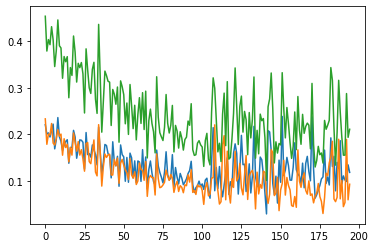

In [28]:
plt.plot(ERRS[0][5:])
plt.plot(ERRS[1][5:])
plt.plot( np.array(ERRS[0][5:]) + np.array(ERRS[1][5:]) )

plt.show()

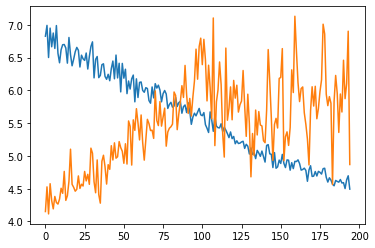

In [29]:
plt.plot(np.array(ERRS[2][5:]) / 10)
plt.plot(ERRS[3][5:])

plt.show()

### Результат

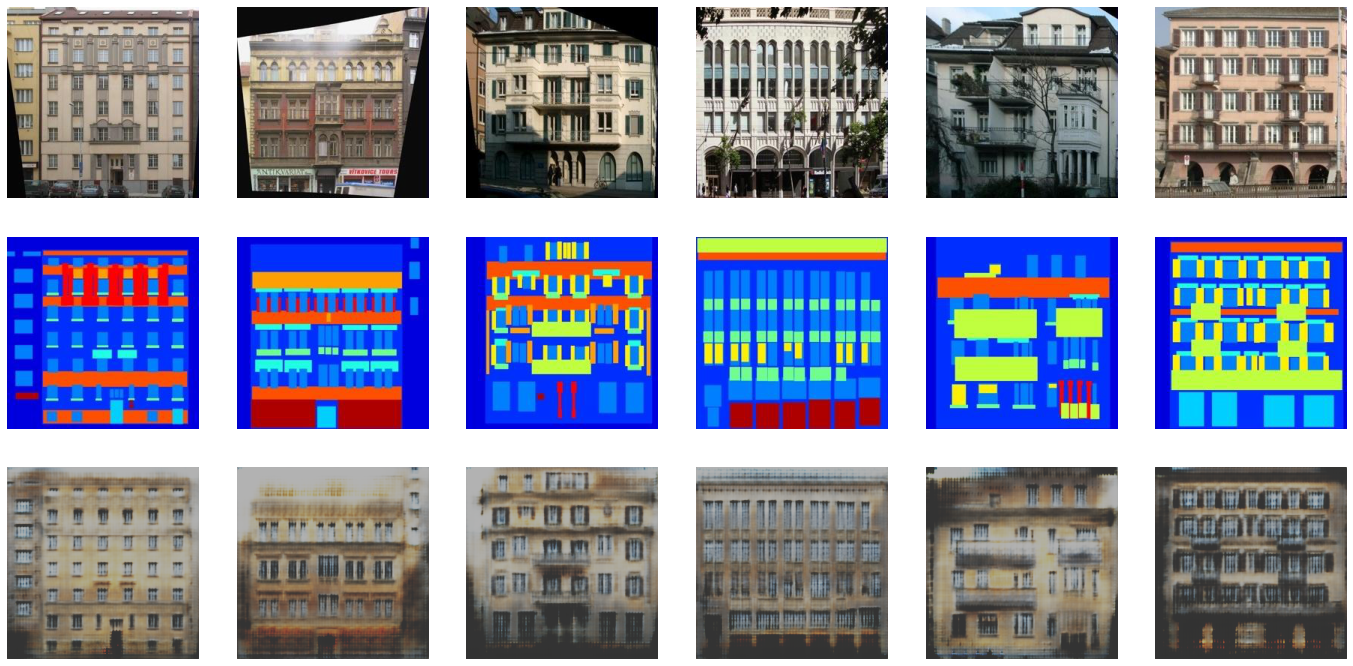

In [30]:
plt.figure(figsize=(24, 12))
for i in range(6):
    a = val_dataset[i+1]

    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(a[0].permute( (1, 2, 0) ) * 0.25 + 0.45 )

    plt.subplot(3, 6, i+7)
    plt.axis("off")
    plt.imshow(a[1].permute( (1, 2, 0) ) * 0.25 + 0.45 )

    plt.subplot(3, 6, i+13)
    plt.axis("off")
    plt.imshow(G( a[1].reshape( (1, 3, 256, 256) ).to(device) )[0].detach().cpu().permute( (1, 2, 0) ) * 0.25 + 0.45 )
plt.show();

Видно, что модель плохо справляется с краями. В обучении сверху может быть крыша, небо или даже обрезка. Также внизу могут быть машины, люди, деревья, магазины, кафе и пр. Центральная часть зданий прорисовывается, но за настоящий снимок, увы, не выдать